## Introduction

This is the sixth in a series of lessons related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the previous lesson we downloaded photometry data from Pan-STARRS, which is available from the same server we've been using to get Gaia data. 

The next step in the analysis is to select candidate stars based on the photometry data.  The following figure from the paper is a color-magnitude diagram for the stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a theoretical isochrone, showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from younger background stars.

## Lesson 6

Here are the steps in this notebook:

1. We'll reload the data from the previous notebook and make a color-magnitude diagram.

2. Then we'll specify a polygon in the diagram that contains stars with the photometry we expect.

3. Then we'll merge the photometry data with the list of candidate stars, storing the result in a Pandas `DataFrame`.

After completing this lesson, you should be able to

* Use Matplotlib to specify a `Polygon` and determine which points fall inside it.

* Use Pandas to merge data from multiple `DataFrames`, much like a database `JOIN` operation.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and a the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  

If you are using this notebook as part of a Carpentries workshop, you should have received setup instructions.

TODO: Add a link to the instructions.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia
    !mkdir data

## Reload the data

The following cell downloads the photometry data we created in the previous notebook.

In [2]:
import os

filename = 'gd1_photo.fits'

if not os.path.exists(filename):
    !wget https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_photo.fits

--2020-09-28 14:53:33--  https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_photo.fits
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/datacarpentry/astronomy-python/gh-pages/data/gd1_photo.fits [following]
--2020-09-28 14:53:34--  https://raw.githubusercontent.com/datacarpentry/astronomy-python/gh-pages/data/gd1_photo.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.116.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.116.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178560 (174K) [application/octet-stream]
Saving to: ‘gd1_photo.fits’

gd1_photo.fits      100%[===================>] 174.38K  --.-KB/s    in 0.06s   

2020-09-28 14:53:34 (2.98 MB/s) - ‘gd1_photo.fits’ saved [178560/178560]



Now we can read the data back into an Astropy `Table`.

In [3]:
from astropy.table import Table

photo_table = Table.read(filename)

## Plotting photometry data

Now that we have photometry data from Pan-STARRS, we can replicate the [color-magnitude diagram](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram) from the original paper:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The y-axis shows the apparent magnitude of each source with the [g filter](https://en.wikipedia.org/wiki/Photometric_system).

The x-axis shows the difference in apparent magnitude between the g and i filters, which indicates color.

Stars with lower values of (g-i) are brighter in g-band than in i-band, compared to other stars, which means they are bluer.

Stars in the lower-left quadrant of this diagram are less bright and less metallic than the others, which means they are [likely to be older](http://spiff.rit.edu/classes/ladder/lectures/ordinary_stars/ordinary.html).

Since we expect the stars in GD-1 to be older than the background stars, the stars in the lower-left are more likely to be in GD-1.

In [4]:
import matplotlib.pyplot as plt

def plot_cmd(table):
    """Plot a color magnitude diagram.
    
    table: Table or DataFrame with photometry data
    """
    y = table['g_mean_psf_mag']
    x = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlim([0, 1.5])
    plt.ylim([14, 22])
    plt.gca().invert_yaxis()

    plt.ylabel('$g_0$')
    plt.xlabel('$(g-i)_0$')

`plot_cmd` uses a new function, `invert_yaxis`, to invert the `y` axis, which is conventional when plotting magnitudes, since lower magnitude indicates higher brightness.

`invert_yaxis` is a little different from the other functions we've used.  You can't call it like this:

```
plt.invert_yaxis()          # doesn't work
```

You have to call it like this:

```
plt.gca().invert_yaxis()          # works
```

`gca` stands for "get current axis".  It returns an object that represents the axes of the current figure, and that object provides `invert_yaxis`.

**In case anyone asks:** The most likely reason for this inconsistency in the interface is that `invert_yaxis` is a lesser-used function, so it's not made available at the top level of the interface.

Here's what the results look like.

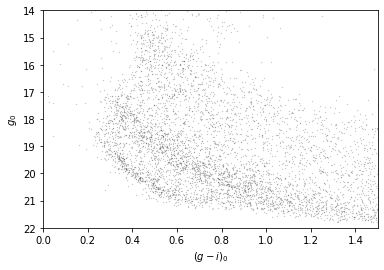

In [5]:
plot_cmd(photo_table)

Our figure does not look exactly like the one in the paper because we are working with a smaller region of the sky, so we don't have as many stars.  But we can see an overdense region in the lower left that contains stars with the photometry we expect for GD-1.

The authors of the original paper derive a detailed polygon that defines a boundary between stars that are likely to be in GD-1 or not.

As a simplification, we'll choose a boundary by eye that seems to contain the overdense region.

## Drawing a polygon

Matplotlib provides a function called `ginput` that lets us click on the figure and make a list of coordinates.

It's a little tricky to use `ginput` in a Jupyter notebook.  
Before calling `plt.ginput` we have to tell Matplotlib to use `TkAgg` to draw the figure in a new window.

When you run the following cell, a figure should appear in a new window.  Click on it 10 times to draw a polygon around the overdense area.  A red cross should appear where you click.

In [6]:
import matplotlib as mpl

if IN_COLAB:
    coords = [(0.2, 17.5), 
              (0.2, 19.5), 
              (0.65, 22),
              (0.75, 21),
              (0.4, 19),
              (0.4, 17.5)] 
else:
    mpl.use('TkAgg')
    plot_cmd(photo_table)
    coords = plt.ginput(10)
    mpl.use('agg')

The argument to `ginput` is the number of times the user has to click on the figure.

The result from `ginput` is a list of coordinate pairs.

In [7]:
coords

[(0.26881720430107525, 17.916114790286976),
 (0.42114695340501784, 19.27740986019132),
 (0.5958781362007168, 20.123620309050775),
 (0.7526881720430108, 20.74908020603385),
 (0.8109318996415771, 21.44812362030905),
 (0.6451612903225806, 21.374540103016926),
 (0.4390681003584229, 20.63870493009566),
 (0.29121863799283154, 20.013245033112582),
 (0.2150537634408602, 19.27740986019132),
 (0.18817204301075263, 18.063281824871233)]

If `ginput` doesn't work for you, you could use the following coordinates.

```
coords = [(0.2, 17.5), 
          (0.2, 19.5), 
          (0.65, 22),
          (0.75, 21),
          (0.4, 19),
          (0.4, 17.5)]
```

The next step is to convert the coordinates to a format we can use to plot them, which is a sequence of `x` coordinates and a sequence of `y` coordinates.  The NumPy function `transpose` does what we want. 

In [8]:
import numpy as np

xs, ys = np.transpose(coords)
xs, ys

(array([0.2688172 , 0.42114695, 0.59587814, 0.75268817, 0.8109319 ,
        0.64516129, 0.4390681 , 0.29121864, 0.21505376, 0.18817204]),
 array([17.91611479, 19.27740986, 20.12362031, 20.74908021, 21.44812362,
        21.3745401 , 20.63870493, 20.01324503, 19.27740986, 18.06328182]))

To display the polygon, we'll draw the figure again and use `plt.plot` to draw the polygon.

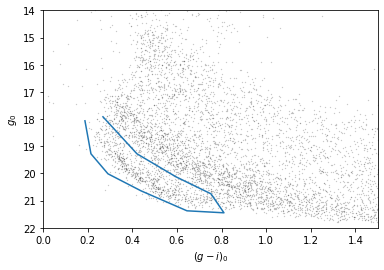

In [9]:
plot_cmd(photo_table)
plt.plot(xs, ys);

If it looks like your polygon does a good job surrounding the overdense area, go on to the next section.  Otherwise you can try again.

If you want a polygon with more points (or fewer), you can change the argument to `ginput`.

The polygon does not have to be "closed".  When we use this polygon in the next section, the last and first points will be connected by a straight line.


## Which points are in the polygon?

Matplotlib provides a `Path` object that we can use to check which points fall in the polygon we selected.

Here's how we make a `Path` using a list of coordinates.

In [10]:
from matplotlib.path import Path

path = Path(coords)
path

Path(array([[ 0.2688172 , 17.91611479],
       [ 0.42114695, 19.27740986],
       [ 0.59587814, 20.12362031],
       [ 0.75268817, 20.74908021],
       [ 0.8109319 , 21.44812362],
       [ 0.64516129, 21.3745401 ],
       [ 0.4390681 , 20.63870493],
       [ 0.29121864, 20.01324503],
       [ 0.21505376, 19.27740986],
       [ 0.18817204, 18.06328182]]), None)

`Path` provides `contains_points`, which figures out which points are inside the polygon.

To test it, we'll create a list with two points, one inside the polygon and one outside.

In [11]:
points = [(0.4, 20), 
          (0.4, 30)]

Now we can make sure `contains_points` does what we expect.

In [12]:
inside = path.contains_points(points)
inside

array([ True, False])

The result is an array of Boolean values.

We are almost ready to select stars whose photometry data falls in this polygon.  But first we need to do some data cleaning.

## Reloading the data

Now we need to combine the photometry data with the list of candidate stars we identified in a previous notebook.  The following cell downloads it:



In [13]:
import os

filename = 'gd1_candidates.hdf5'

if not os.path.exists(filename):
    !wget https://github.com/datacarpentry/astronomy-python/raw/gh-pages/data/gd1_candidates.hdf5

In [14]:
import pandas as pd

candidate_df = pd.read_hdf(filename, 'candidate_df')

`candidate_df` is the Pandas DataFrame that contains the results from Notebook XX, which selects stars likely to be in GD-1 based on proper motion.  It also includes position and proper motion transformed to the ICRS frame.

## Merging photometry data

Before we select stars based on photometry data, we have to solve two problems:

1. We only have Pan-STARRS data for some stars in `candidate_df`.

2. Even for the stars where we have Pan-STARRS data in `photo_table`, some photometry data is missing.

We will solve these problems in two step:

1. We'll merge the data from `candidate_df` and `photo_table` into a single Pandas `DataFrame`.

2. We'll use Pandas functions to deal with missing data.

`candidate_df` is already a `DataFrame`, but `results` is an Astropy `Table`.  Let's convert it to Pandas:

In [15]:
photo_df = photo_table.to_pandas()

for colname in photo_df.columns:
    print(colname)

source_id
g_mean_psf_mag
i_mean_psf_mag


Now we want to combine `candidate_df` and `photo_df` into a single table, using `source_id` to match up the rows.

You might recognize this task; it's the same as the JOIN operation in ADQL/SQL.

Pandas provides a function called `merge` that does what we want.  Here's how we use it.

In [16]:
merged = pd.merge(candidate_df, 
                  photo_df, 
                  on='source_id', 
                  how='left')
merged.head()

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2,g_mean_psf_mag,i_mean_psf_mag
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633,NaN,NaN
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,0.199466,NaN,-59.247330,-2.016078,-7.527126,1.748779,17.8978,17.517401
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800,19.2873,17.678101
3,635535454774983040,137.837752,18.864007,-4.335041,-14.492309,0.314514,0.102775,NaN,-59.785300,-1.594569,-9.357536,-1.218492,16.9238,16.478100
4,635875994141946752,138.236059,19.205240,-2.593401,-14.479242,0.855662,0.070623,NaN,-59.295378,-1.730187,-8.381356,-2.723334,NaN,NaN


The first argument is the "left" table, the second argument is the "right" table, and the keyword argument `on='source_id'` specifies a column to use to match up the rows.

The argument `how='left'` means that the result should have all rows from the left table, even if some of them don't match up with a row in the right table.

If you are interested in the other options for `how`, you can [read the documentation of `merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html).

You can also do different types of join in ADQL/SQL; [you can read about that here](https://www.w3schools.com/sql/sql_join.asp).

The result is a `DataFrame` that contains the same number of rows as `candidate_df`. 

In [17]:
len(candidate_df), len(photo_df), len(merged)

(13976, 7189, 13976)

And all columns from both tables.

In [18]:
for colname in merged.columns:
    print(colname)

source_id
ra
dec
pmra
pmdec
parallax
parallax_error
radial_velocity
phi1
phi2
pm_phi1
pm_phi2
g_mean_psf_mag
i_mean_psf_mag


**Detail** You might notice that Pandas also provides a function called `join`; it does almost the same thing, but the interface is slightly different.  We think `merge` is a little easier to use, so that's what we chose.  It's also more consistent with JOIN in SQL, so if you learn how to use `pd.merge`, you are also learning how to use SQL JOIN.

Also, someone might ask why we have to use Pandas to do this join; why didn't we do it in ADQL.  The answer is that we could have done that, but since we already have the data we need, we should probably do the computation locally rather than make another round trip to the Gaia server.

## Missing data

Let's add columns to the merged table for magnitude and color.

In [19]:
merged['mag'] = merged['g_mean_psf_mag']
merged['color'] = merged['g_mean_psf_mag'] - merged['i_mean_psf_mag']

These columns contain the special value `NaN` where we are missing data.

We can use `notnull` to see which rows contain value data, that is, not null values.

In [20]:
merged['color'].notnull()

0        False
1         True
2         True
3         True
4        False
         ...  
13971     True
13972     True
13973    False
13974     True
13975     True
Name: color, Length: 13976, dtype: bool

And `sum` to count the number of valid values.

In [21]:
merged['color'].notnull().sum()

7189

For scientific purposes, it's not obvious what we should do with candidate stars if we don't have photometry data.  Should we give them the benefit of the doubt or leave them out?

In part the answer depends on the goal: are we trying to identify more stars that might be in GD-1, or a smaller set of stars that have higher probability?

In the next section, we'll leave them out, but you can experiment with the alternative.

## Selecting based on photometry

Now let's see how many of these points are inside the polygon we chose.

We can use a list of column names to select `color` and `mag`.

In [22]:
points = merged[['color', 'mag']]
points.head()

,color,mag
0,NaN,NaN
1,0.3804,17.8978
2,1.6092,19.2873
3,0.4457,16.9238
4,NaN,NaN


The result is a `DataFrame` that can be treated as a sequence of coordinates, so we can pass it to `contains_points`:

In [23]:
inside = path.contains_points(points)
inside

array([False, False, False, ..., False, False, False])

The result is a Boolean array.  We can use `sum` to see how many stars fall in the polygon.

In [24]:
inside.sum()

739

Now we can use `inside` as a mask to select stars that fall inside the polygon.

In [25]:
selected = merged[inside]

Let's make a color-magnitude plot one more time, highlighting the selected stars with green `x` marks.

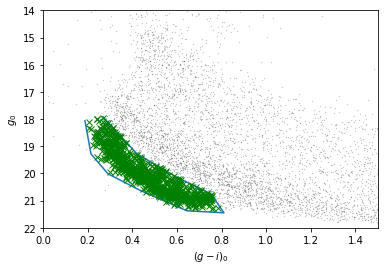

In [26]:
plot_cmd(photo_table)
plt.plot(xs, ys)

plt.plot(selected['color'], selected['mag'], 'gx');

It looks like the selected stars are, in fact, inside the polygon, which means they have photometry data consistent with GD-1.

Finally, we can plot the coordinates of the selected stars:

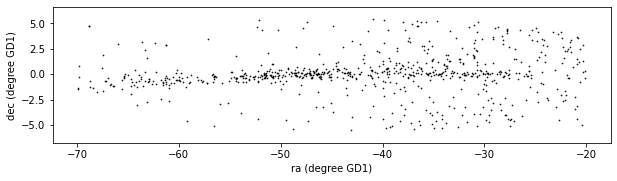

In [27]:
plt.figure(figsize=(10,2.5))

x = selected['phi1']
y = selected['phi2']

plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');

This example includes two new Matplotlib commands:

* `figure` creates the figure.  In previous examples, we didn't have to use this function; the figure was created automatically.  But when we call it explicitly, we can provide arguments like `figsize`, which sets the size of the figure.

* `axis` with the parameter `equal` sets up the axes so a unit is the same size along the `x` and `y` axes.

In an example like this, where `x` and `y` represent coordinates in space, equal axes ensures that the distance between points is represented accurately.   

## Write the data

Let's write the merged DataFrame to a file.

In [28]:
filename = 'gd1_merged.hdf5'

merged.to_hdf(filename, 'merged')

## Summary

In this notebook, we worked with two datasets: the list of candidate stars from Gaia and the photometry data from Pan-STARRS.

We drew a color-magnitude diagram and used it to identify stars we think are likely to be in GD-1.

Then we used a Pandas `merge` operation to combine the data into a single `DataFrame`.

## Best practices

* If you want to perform something like a database `JOIN` operation with data that is in a Pandas `DataFrame`, you can use the `join` or `merge` function.  In many cases, `merge` is easier to use because the arguments are more like SQL.

* Use Matplotlib options to control the size and aspect ratio of figures to make them easier to interpret.  In this example, we scaled the axes so the size of a degree is equal along both axes.

* Matplotlib also provides operations for working with points, polygons, and other geometric entities, so it's not just for making figures.